# Test data loading from different sources

- ARC-AGI
- ARC-AGI-2
- SRaven
- BBH

### Colab setup -- just run the below cell

In [ ]:
# ==== NOTEBOOK COLAB SETUP - RUN THIS CELL FIRST ====

def is_colab():
    """
    Check if the code is running in Google Colab
    
    Returns:
        bool: True if running in Colab, False otherwise
    """
    try:
        import google.colab
        return True
    except ImportError:
        return False

colab = is_colab()
if colab:

    import os
    import sys
    import importlib.util
    from google.colab import drive, userdata

    # Mount Google Drive
    try:
        drive.mount('/content/drive')
    except:
        print("Trying to force remount drive...")
        drive.mount('/content/drive', force_remount=True)

    # Reset to a known directory
    os.chdir('/content')

    # Clone or update repository
    repo_path = "/content/repeng"
    github_username = 'samj-ai'

    print(f"Cloning or updating repo from https://github.com/{github_username}/repeng.git...")
    !git clone https://github.com/{github_username}/repeng.git {repo_path} 2>/dev/null || (cd {repo_path} && git pull)

    # Verify repo exists before proceeding
    if os.path.exists(repo_path):
        # Change to repo directory
        os.chdir(repo_path)
        print(f"Current directory: {os.getcwd()}")

        # Install dependencies (use quiet mode to reduce output)
        print("Installing requirements...")
        !pip install -q -r requirements.txt

        # Set environment variables
        try:
            os.environ['HF_TOKEN'] = userdata.get('HF_MISTRAL7B_KEY')
            print("HF token loaded successfully")
        except Exception as e:
            print(f"Warning: Could not load HF token: {e}")

        # Add repo to path in multiple ways to ensure it works
        if repo_path not in sys.path:
            sys.path.append(repo_path)
        sys.path.insert(0, os.getcwd())

        # Import colab_setup using the robust method that worked in the launcher
        try:
            # Try direct module import first
            import colab_setup
            setup_environment = colab_setup.setup_environment
        except ImportError:
            # Fall back to importlib if direct import fails
            print("Using importlib to load colab_setup...")
            spec = importlib.util.spec_from_file_location("colab_setup", 'colab_setup.py')
            colab_setup = importlib.util.module_from_spec(spec)
            sys.modules["colab_setup"] = colab_setup
            spec.loader.exec_module(colab_setup)
            setup_environment = colab_setup.setup_environment

        # Run setup environment
        setup_environment()
        print("✅ Environment setup complete - ready to run notebook!")
    else:
        print(f"Error: Failed to clone repository to {repo_path}")

In [71]:
import os
import sys
import json

import jax
import jax.numpy as jnp
import jax.random as random

import numpy as np
from einops import rearrange
import itertools
from functools import partial
import matplotlib.pyplot as plt

# make SRaven datasets
sys.path.append(os.path.abspath('..'))
from algorithms.hyla.hyla.data.raven import create_raven_datasets

In [100]:
# Test SRaven datasets

num_features = 8
feature_maxval = 64
grid_size = 3
permute_features = True

with jax.disable_jit(False):
    (ds_train, ds_eval, ds_callback), _ = create_raven_datasets(
        batch_size := 128,
        seq_len := ((9 - 1) * num_features) + num_features,
        num_train=1280, # 128000
        num_test=128,
        num_ood=128,
        num_features=num_features,
        feature_maxval=feature_maxval,
        grid_size=grid_size,
        permute_features=permute_features,
        frac_ood=0.25,
        seed=0,
    )

In [101]:
## notes to self
## from --> Experiment: for step, batch in enumerate(iter(self.train_loader)):
## from --> Experiment:

n_batches = 4
batches = []
di_train = iter(ds_train)
for n, b in zip(range(n_batches), ds_train):
    batches.append(b)

In [102]:
# examine some batches
# raven batches are shape (examples, num_features * 9, feature_maxval)
bx = batches[0].x
by = batches[0].y
print(bx.shape)
print(by.shape)

(128, 72, 64)
(128, 8)


In [103]:
# examine single example
ex = bx[0]
ex = rearrange(ex, '(a b) c -> a b c', a=9, b=8)
# verify one-hot encoding
jnp.unique(ex, return_counts=True)

(Array([0., 1.], dtype=float32), Array([4544,   64], dtype=int32))

In [104]:
ex = ex.argmax(axis=-1)
ex.shape

(9, 8)

In [105]:
data = ex

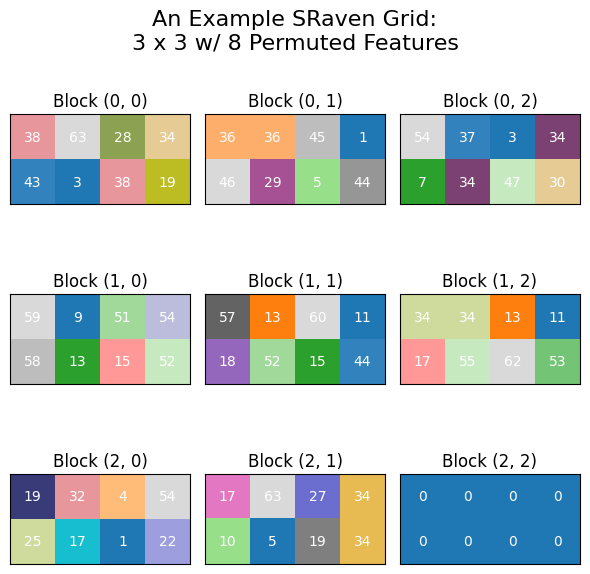

In [109]:
import matplotlib.colors as mcolors

sraven_title = 'An Example SRaven Grid:\n3 x 3 w/ 8 Permuted Features'
size_per_subplot = 2
fig, axes = plt.subplots(3, 3, figsize=(3 * size_per_subplot, 3 * size_per_subplot))
axes = axes.flatten()
# cmap = plt.cm.viridis

# nicer formatting
palette1 = plt.cm.tab20.colors
palette2 = plt.cm.tab20b.colors
palette3 = plt.cm.tab20c.colors
combined_colors = list(palette1) + list(palette2) + list(palette3)
cmap = mcolors.ListedColormap(combined_colors)
cmap.name = 'combined_qualitative'

# Loop through the 9 blocks (3×3 grid)
for block_idx in range(9):
    # Calculate row and column in the original array
    block_row = block_idx // 3
    block_col = block_idx % 3
    
    # Extract the corresponding 2×4 sub-array
    # Each block corresponds to one row of the original array
    block_data = data[block_idx].reshape(2, 4)
    
    # Plot this block in its corresponding axis
    im = axes[block_idx].imshow(block_data, cmap=cmap)
    
    # Add text annotations with values
    for i in range(2):
        for j in range(4):
            axes[block_idx].text(j, i, f'{int(block_data[i, j])}', 
                              ha='center', va='center', color='white')
    
    # Add titles to each block
    axes[block_idx].set_title(f'Block ({block_row}, {block_col})')
    
    # Remove ticks for cleaner appearance
    axes[block_idx].set_xticks([])
    axes[block_idx].set_yticks([])

plt.tight_layout()
plt.suptitle(f'{sraven_title}', fontsize=16, y=1.05)
plt.show()

# Load some ARC data -- ensure consistent formatting

In [111]:
# Opening and loading JSON
def load_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    return data

# Saving JSON
def save_json(data, file_path):
    with open(file_path, 'w') as f:
        json.dump(data, f, indent=4)  # indent for pretty printing

In [112]:
# Note: training data visualized here
dataset_name = 'training'

filepath = f'../data/ARC-AGI-2/data/{dataset_name}/'
filenames = os.listdir(filepath)
print(f'ARC-AGI-2 {dataset_name} files:')
print('----------------------')
print('\n'.join(filenames[:10]))
print('...')

ARC-AGI-2 training files:
----------------------
a85d4709.json
c8cbb738.json
8e1813be.json
a699fb00.json
20fb2937.json
5c2c9af4.json
f0afb749.json
44f52bb0.json
94414823.json
23581191.json
...


In [113]:
# FILE FORMAT (one .json file per task):
## -----------------------------
# TASK: { [ { [[]] } ] }
# - 'train': key
# -- examples: [{ [[]] }]
# --- 'input': key
# ---- int[[]]
# --- 'output': key
# ---- int[[]]
# - 'test': key
# --- ibid. ...

index = 0
data = load_json(os.path.join(filepath, filenames[index]))
print(f'Filename:` {filenames[index]}')

Filename:` a85d4709.json


In [114]:
inputs = [data['train'][i]['input'] for i in range(len(data['train']))]
outputs = [data['train'][i]['output'] for i in range(len(data['train']))]
inputs, outputs

([[[5, 0, 0], [0, 5, 0], [5, 0, 0]],
  [[0, 0, 5], [0, 0, 5], [0, 0, 5]],
  [[0, 5, 0], [0, 0, 5], [0, 5, 0]],
  [[0, 0, 5], [0, 5, 0], [5, 0, 0]]],
 [[[2, 2, 2], [4, 4, 4], [2, 2, 2]],
  [[3, 3, 3], [3, 3, 3], [3, 3, 3]],
  [[4, 4, 4], [3, 3, 3], [4, 4, 4]],
  [[3, 3, 3], [4, 4, 4], [2, 2, 2]]])

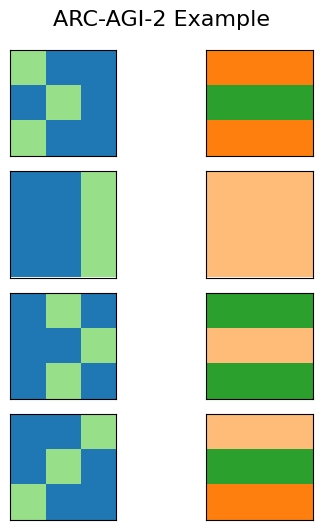

In [116]:
plt.rcParams['axes.titlesize'] = 12
arc2_title = 'ARC-AGI-2 Example'

# global values
vmin = 0
vmax = 20

n_examples = len(data['train'])
fig, axes = plt.subplots(n_examples, 2, figsize=(5, 5))
cmap = plt.cm.tab20

for r in range(n_examples):
    for c, label in enumerate(['input', 'output']):
        im = axes[r][c].imshow(data['train'][r][label], cmap=cmap, vmin=vmin, vmax=vmax)    
        # Remove ticks for cleaner appearance
        axes[r][c].set_xticks([])
        axes[r][c].set_yticks([])

plt.tight_layout()
plt.suptitle(f'{arc2_title}', fontsize=16, y=1.05)
plt.show()

# Data Augmentation Primitives + Pretraining

Primitives:
- random collection of random colors
- row-wise and column-wise independent translations
- multi-column and multi-row grouped translations (independent between groups)
- rotations
- reflections
- rescalings

In [19]:
def display(grids_I, grids_O=None, size_per_grid=5):
    """
    Convenience function to display input and optional output grids.
    
    Args:
    - grids_I: Input grid(s) to display
    - grids_O: Optional output grid(s) to display alongside input grids
    """
    # Determine number of columns based on whether output grids are provided
    num_cols = 1 if grids_O is None else 2
    
    # Convert to JAX arrays
    grids_I = jnp.array(grids_I)
    if grids_O is not None:
        grids_O = jnp.array(grids_O)
    
    # Ensure input grids have a channel dimension if it's missing
    if len(grids_I.shape) == 2:
        grids_I = rearrange(grids_I, '... h w -> ... 1 h w')
    
    # Determine number of rows (number of grids to display)
    num_rows = grids_I.shape[0]
    
    # Create subplot grid
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(size_per_grid*num_cols, size_per_grid*num_rows))
    
    # Handle different subplot configurations
    if num_rows == 1 and num_cols == 1:
        ax = np.array([[ax]])
    elif num_rows == 1:
        ax = np.array([ax])
    elif num_cols == 1:
        ax = ax[:, np.newaxis]
    
    # Display grids
    for i in range(num_rows):
        for j in range(num_cols):
            # Select grid to display (input or output)
            grid_to_display = grids_I[i] if j == 0 else grids_O[i]
            
            # Display the grid
            ax[i, j].imshow(grid_to_display, cmap=plt.cm.tab10)
            ax[i, j].axis('off')
    
    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()


In [21]:
def generate_grid_batch(key, batch_size, size_x=None, size_y=None, max_value=10, size_max=30, sparsity=0.8):
    """Create a batch of random grids.
    
    Args:
        key: JAX random key
        batch_size: Number of grids to generate
        size_x: x dimension of grids (if None, randomly chosen)
        size_y: y dimension of grids (if None, randomly chosen)
        max_value: maximum value in grids
        size_max: maximum size if size_x or size_y is None
        sparsity: fraction of grid to be zero
        
    Returns:
        Batch of grids with shape (batch_size, size_x, size_y)
    """
    # Split key for batch generation
    keys = random.split(key, batch_size)
    
    # Handle optional size_x and size_y once for all grids
    if size_x is None and size_y is None:
        # Generate a random size for all grids in the batch
        size_key, grid_key = random.split(key)
        size_x, size_y = random.randint(size_key, (2,), 1, size_max)
    elif size_x is not None and size_y is None:
        size_y = size_x
    elif size_y is not None and size_x is None:
        size_x = size_y
    
    # Define a function to generate a single grid with fixed size
    def generate_single_grid(key):
        key1, key2 = random.split(key)
        # Generate random values
        grid = random.randint(key1, (size_x, size_y), 0, max_value)
        # Apply sparsity mask
        mask = random.uniform(key2, (size_x, size_y)) < sparsity
        return jnp.where(mask, 0, grid)
    
    # Vectorize the grid generation function over the batch dimension
    return jax.vmap(generate_single_grid)(keys)

# single grid generator
generate_grid = partial(lambda key,
                        **kwargs: generate_grid_batch(key, batch_size=1, **kwargs)[0])

# ------------- EXAMPLE USAGE -------------

key = random.PRNGKey(0)
# Generate 16 grids of size 10x10
grids = generate_grid_batch(key, batch_size=16, size_x=10, size_y=10)
print(grids.shape)  # (16, 10, 10)
# Generate 8 grids with random sizes (all grids will have the same random size)
random_sized_grids = generate_grid_batch(key, batch_size=8)


(16, 10, 10)


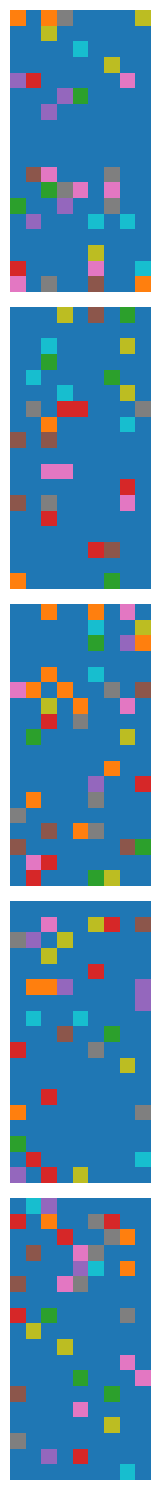

In [24]:
key = random.key(12)
key, key1 = random.split(key)
rg = generate_grid_batch(key1, batch_size=5)
display(rg, size_per_grid=3)

## TODO:

- Essential: ensure these operate on a batch of examples
  - This may require that we separate the translation from its application
  - This way, we form "tasks" of demonstrated IO pairs.
- Less important, still good: make these all operate on huge arrays that can be batched for extreme efficiency increase

In [27]:
# ----------- HELPFUL FRIENDS ------------

def random_select(key, array, p=0.5):
    """
    Randomly select elements from an array with probability p for each element.
    
    Args:
        key: JAX PRNG key
        array: JAX array to select from
        p: Probability of selecting each element (default 0.5)
    
    Returns:
        JAX array with selected elements
    """
    mask = jax.random.uniform(key, array.shape) < p
    return array[mask]

# ---------- PERMUTE ----------
def generate_permute_config(key, indices, axis_number, sparsity=0.8):
    """Generate configuration for permuting a grid along a certain axis.
    
    Args:
        key: JAX random key
        indices: Array of indices to permute (e.g., jnp.arange(grid_shape[0]))
        axis_number: Integer axis (0 for rows, 1 for columns)
        sparsity: Fraction (on average) of columns / rows to be permuted.
    """
    key1, key2 = random.split(key)
    subset_to_permute = random_select(key1, indices, p=sparsity)
    permuted_subset = random.permutation(key2, subset_to_permute)
    perm = indices.at[subset_to_permute].set(permuted_subset)
    return {"perm": perm, "axis": axis_number}

def apply_permute(grid, config):
    """Apply permutation to a grid using the provided configuration."""
    perm, axis = config["perm"], config["axis"]
    if axis == 0:  # Permute rows
        return grid[perm]
    elif axis == 1:  # Permute columns
        return grid[:, perm]
    else:
        raise ValueError(f"Unsupported axis: {axis}")

def generate_permute_rows_config(key, grid_shape, sparsity):
    """Generate configuration for permuting rows of a grid."""
    return generate_permute_config(key, jnp.arange(grid_shape[0]), 0, sparsity=sparsity)

def generate_permute_columns_config(key, grid_shape, sparsity):
    """Generate configuration for permuting columns of a grid."""
    return generate_permute_config(key, jnp.arange(grid_shape[1]), 1, sparsity=sparsity)

def generate_permute_colors_config(key, sparsity, max_colors):
    """Generate configuration for permuting colors of a grid."""
    key1, key2 = random.split(key)
    indices = jnp.arange(max_colors)
    indices_to_permute = random_select(key1, indices, p=sparsity)
    permuted_indices = random.permutation(key2, indices_to_permute)
    perm = indices.at[indices_to_permute].set(permuted_indices)
    return {"perm": perm}

def apply_permute_rows(grid, config):
    """Apply row permutation to a grid."""
    return apply_permute(grid, config)

def apply_permute_columns(grid, config):
    """Apply column permutation to a grid."""
    return apply_permute(grid, config)

def apply_permute_colors(grid, config):
    """Apply color permutation to a grid."""
    return grid[:, config["perm"]]

# ---------- ROTATE ----------
def generate_rotate_config(key):
    """Generate configuration for rotating a grid."""
    n_rotations = random.randint(key, (1,), 0, 4)[0]
    return {"n_rotations": n_rotations}

def apply_rotate(grid, config):
    """Apply rotation to a grid using the provided configuration."""
    return jnp.rot90(grid, k=config["n_rotations"])

# ---------- FLIP ----------
def generate_flip_config(key, n_axes):
    """Generate configuration for flipping a grid."""
    axis = random.randint(key, (1,), 0, n_axes)[0]
    return {"axis": axis}

def apply_flip(grid, config):
    """Apply flip to a grid using the provided configuration."""
    return jnp.flip(grid, axis=config["axis"])

# ---------- TRANSPOSE ----------
def generate_transpose_config():
    """Generate configuration for transposing a grid."""
    return {}  # No parameters needed

def apply_transpose(grid, config):
    """Apply transpose to a grid."""
    return jnp.transpose(grid)

# ---------- TRANSLATE ----------
def generate_translate_config(key, grid_shape, max_shift=None, roll=True):
    """Generate configuration for translating a grid."""
    if max_shift is None:
        max_shift = grid_shape[0] // 2
        
    key1, key2 = random.split(key)
    dx = random.randint(key1, (1,), -max_shift, max_shift + 1)[0]
    dy = random.randint(key2, (1,), -max_shift, max_shift + 1)[0]
    
    return {"dx": dx, "dy": dy, "roll": roll}

def apply_translate(grid, config):
    """Apply translation to a grid using the provided configuration."""
    dx, dy, roll = config["dx"], config["dy"], config["roll"]
    
    # First roll the grid
    grid = jnp.roll(grid, shift=(dx, dy), axis=(0, 1))
    
    # If not rolling, create a mask to zero out wrapped elements
    if not roll:
        mask = jnp.ones_like(grid)
        if dx > 0:
            mask = mask.at[:, :dx].set(0)  # Zero out left columns
        elif dx < 0:
            mask = mask.at[:, dx:].set(0)  # Zero out right columns
        if dy > 0:
            mask = mask.at[:dy, :].set(0)  # Zero out top rows
        elif dy < 0:
            mask = mask.at[dy:, :].set(0)  # Zero out bottom rows
        grid = grid * mask
        
    return grid

# ---------- SHIFT DIMENSIONS ----------
def generate_shift_dims_config(key, grid_shape, axis=1, max_shift=None, sparsity=0.8):
    """Generate configuration for shifting dimensions of a grid.
    
    Args:
        key: JAX random key
        grid_shape: Shape of the grid
        axis: Axis along which to shift (0 for rows, 1 for columns)
        max_shift: Maximum shift amount
    """
    if max_shift is None:
        max_shift = grid_shape[0] // 4
    key1, key2 = random.split(key)
    # Get the size of the axis perpendicular to the one we're shifting
    perp_size = grid_shape[1] if axis == 0 else grid_shape[0]
    shifts = random.randint(key1, (perp_size,), -max_shift, max_shift + 1)
    # Apply sparsity
    keeps = random.random(key2, (perp_size,)) < sparsity
    shifts = jnp.where(keeps, shifts, 0)
    return {"shifts": shifts, "axis": axis}

def apply_shift_dims(grid, config):
    """Apply dimension shifts to a grid using the provided configuration."""
    shifts = config["shifts"]
    axis = config["axis"]
    
    # Define the shift_line function
    def shift_line(dim, shift):
        return jnp.roll(dim, shift, axis=0)
    
    if axis == 0:  # Shift rows
        # Each row gets shifted by its corresponding amount
        grid_st = jax.vmap(shift_line, in_axes=(0, 0))(grid, shifts)
        return grid_st
    else:  # Shift columns
        # Transpose to get columns as the first dimension
        grid_t = jnp.transpose(grid, (1, 0) + tuple(range(2, len(grid.shape))))
        grid_st = jax.vmap(shift_line, in_axes=(0, 0))(grid_t, shifts)
        # Transpose back to original shape
        return jnp.transpose(grid_st, (1, 0) + tuple(range(2, len(grid.shape))))

# ---------- PATCH ----------
def generate_patch_config(key, grid_shape, patch_x=None, patch_y=None, patch_value=0):
    """Generate configuration for applying a patch to a grid."""
    size_x, size_y = grid_shape
    
    # Handle optional patch_x and patch_y
    if patch_x is None and patch_y is None:
        patch_x, patch_y = random.randint(key, (2,), 0, min(size_x, size_y))
    elif patch_x is not None and patch_y is None:
        patch_y = patch_x
    elif patch_y is not None and patch_x is None:
        patch_x = patch_y
        
    return {"patch_x": patch_x, "patch_y": patch_y, "patch_value": patch_value}

def apply_patch(grid, config):
    """Apply a patch to a grid using the provided configuration."""
    patch_x, patch_y, patch_value = config["patch_x"], config["patch_y"], config["patch_value"]
    
    return grid.at[patch_x:patch_x + grid.shape[0], patch_y:patch_y + grid.shape[1]].set(patch_value)

# ---------- RESCALE ----------
def generate_rescale_config(key, max_scale_factor=6):
    """Generate configuration parameters for rescaling."""
    scale_factor = jax.random.randint(key, (1,), 1, max_scale_factor + 1)[0]
    return {"scale_factor": scale_factor}

def apply_rescale(grid, config):
    """Apply rescaling using the provided configuration."""
    scale_factor = config["scale_factor"]
    size_x, size_y = grid.shape
    new_size_x = int(size_x * scale_factor)
    new_size_y = int(size_y * scale_factor)
    
    i_indices = jnp.arange(new_size_x)
    j_indices = jnp.arange(new_size_y)
    x_indices = (i_indices // scale_factor).astype(jnp.int32)
    y_indices = (j_indices // scale_factor).astype(jnp.int32)
    
    X, Y = jnp.meshgrid(x_indices, y_indices, indexing='ij')
    return grid[X, Y]

# ---------- CROP ----------
def generate_crop_config(key, grid_shape, crop_x=None, crop_y=None, ul_corner_x=None, ul_corner_y=None):
    """Generate configuration for cropping a grid."""
    size_x, size_y = grid_shape
    
    # Handle optional parameters with reasonable defaults
    if crop_x is None:
        crop_x = random.randint(key, (1,), 0, size_x // 2)[0]
    if crop_y is None:
        crop_y = random.randint(key, (1,), 0, size_y // 2)[0]
    if ul_corner_x is None:
        ul_corner_x = 0
    if ul_corner_y is None:
        ul_corner_y = 0
        
    return {
        "crop_x": crop_x,
        "crop_y": crop_y,
        "ul_corner_x": ul_corner_x,
        "ul_corner_y": ul_corner_y
    }

def apply_crop(grid, config):
    """Apply cropping to a grid using the provided configuration."""
    crop_x = config["crop_x"]
    crop_y = config["crop_y"]
    ul_corner_x = config["ul_corner_x"]
    ul_corner_y = config["ul_corner_y"]
    
    size_x, size_y = grid.shape
    return grid.at[
        ul_corner_x:ul_corner_x + size_x - crop_x, 
        ul_corner_y:ul_corner_y + size_y - crop_y
    ].set(0)

# ---------- TRANSFORM PIPELINE ----------
def generate_transform_pipeline(key, grid_shape, transform_types, transform_probs=None, sparsity=0.8, max_colors=10):
    """Generate a pipeline of transformation configurations.
    
    Args:
        key: JAX random key
        grid_shape: Shape of the grid to transform
        transform_types: List of transformation types to consider
        transform_probs: Optional probabilities for each transform
        
    Returns:
        List of (transform_fn, config) tuples
    """
    keys = jax.random.split(key, len(transform_types) + 1)
    pipeline = []
    
    if transform_probs is None:
        transform_probs = [0.5] * len(transform_types)
    
    transform_probs_array = jnp.array(transform_probs)
    apply_transform = jax.random.uniform(keys[0], (len(transform_types),)) < transform_probs_array
    
    # Map of transform types to their generator and application functions
    optional_args = {'sparsity': sparsity}
    color_args = {'sparsity': sparsity, 'max_colors': max_colors}
    transform_map = {
        "permute_rows": (generate_permute_rows_config, apply_permute_rows, optional_args),
        "permute_columns": (generate_permute_columns_config, apply_permute_columns,  optional_args),
        "permute_colors": (generate_permute_colors_config, apply_permute_colors, color_args),
        "rotate": (generate_rotate_config, apply_rotate),
        "flip": (generate_flip_config, apply_flip),
        "transpose": (generate_transpose_config, apply_transpose),
        "translate": (generate_translate_config, apply_translate),
        "shift_dims": (generate_shift_dims_config, apply_shift_dims, optional_args),
        "patch": (generate_patch_config, apply_patch),
        "rescale": (generate_rescale_config, apply_rescale),
        "crop": (generate_crop_config, apply_crop)
    }
    
    # Generate configs for each selected transform
    for i, (apply, transform_type) in enumerate(zip(apply_transform, transform_types)):
        if apply:
            if transform_type in transform_map:
                generator_fn, apply_fn = transform_map[transform_type][:2]
                opt = len(transform_map[transform_type]) > 2
                if opt:
                    optional_args = transform_map[transform_type][2]
                # Handle functions that need grid_shape
                if transform_type in ["permute_rows", "permute_columns",  
                                      "translate", "shift_dims", "patch", "crop"]:
                    if opt:
                        config = generator_fn(keys[i+1], grid_shape, **optional_args)
                    else:
                        config = generator_fn(keys[i+1], grid_shape)
                else:
                    if opt:
                        config = generator_fn(keys[i+1], **optional_args)
                    else:
                        config = generator_fn(keys[i+1])
                pipeline.append((apply_fn, config))
    return pipeline

def apply_transform_pipeline(grid, pipeline):
    """Apply a pipeline of transformations to a grid."""
    for transform_fn, config in pipeline:
        grid = transform_fn(grid, config)
    return grid

def batch_apply_transform_pipeline(grids, pipeline):
    """Apply the same transform pipeline to a batch of grids.
    
    Args:
        grids: Array of shape (batch_size, height, width, ...)
        pipeline: Transform pipeline from generate_transform_pipeline
        
    Returns:
        Transformed grids
    """
    return jax.vmap(lambda grid: apply_transform_pipeline(grid, pipeline))(grids)

## test transform pipeline

In [28]:
key = random.key(24)
grid_shape = (10, 10)
transform_types = [
    "permute_rows", "permute_columns", "permute_colors"
]
pl = generate_transform_pipeline(key, grid_shape, transform_types)
pl

[(<function __main__.apply_permute_rows(grid, config)>,
  {'perm': Array([5, 1, 2, 9, 4, 0, 6, 7, 3, 8], dtype=int32), 'axis': 0}),
 (<function __main__.apply_permute_columns(grid, config)>,
  {'perm': Array([8, 3, 0, 4, 6, 9, 5, 2, 1, 7], dtype=int32), 'axis': 1}),
 (<function __main__.apply_permute_colors(grid, config)>,
  {'perm': Array([0, 3, 8, 2, 1, 4, 5, 7, 6, 9], dtype=int32)})]

In [29]:
grid_batch_I = generate_grid_batch(key, batch_size=5, size_x=10, size_y=10, max_value=10)

In [30]:
grid_batch_O = batch_apply_transform_pipeline(grid_batch_I, pl)

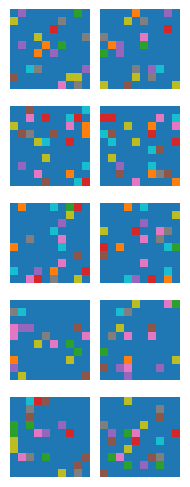

In [31]:
display(grid_batch_I, grid_batch_O, size_per_grid=1)

# Test Basic TTT leave-one-out method

In [70]:
from algorithms.marc.arclib.arc import Task, Example

In [68]:
def generate_ttt_data(task, n=1):
    initial_tasks = []
    N = len(task.train_examples)
    for i in range(N):
        examples = task.train_examples.copy()
        indices = set(range(N)) - {i}
        # we already remove i, so we need to remove n-1 more
        combs = list(itertools.combinations(indices, n - 1))
        combs = [indices - set(comb) for comb in combs]
        for comb in combs:
            initial_tasks.append(
                Task(train_examples=[examples[j] for j in comb], test_examples=examples[i])
            )
    # TODO: Add Augmentation
    return initial_tasks

In [69]:
def to_task(input_grids, output_grids, test_input, test_output):
    """Convert input and output grids to a Task object."""
    train_examples = []
    for i in range(len(input_grids)):
        train_examples.append(Example(input_grids[i], output_grids[i]))
    test_example = Example(test_input, test_output)
    return Task(train_examples=train_examples, test_example=test_example)

def to_task_lazy(input_grids, output_grids, test_index=-1):
    t = to_task(jnp.delete(input_grids, test_index, axis=0), 
            jnp.delete(output_grids, test_index, axis=0), 
            input_grids[test_index], output_grids[test_index]
            )
    return t

def from_task(task):
    """Convert a Task object to input and output grids."""
    input_grids = []
    output_grids = []
    for example in task.train_examples:
        input_grids.append(example.input)
        output_grids.append(example.output)
    test_input = task.test_example.input
    test_output = task.test_example.output
    return jnp.array(input_grids), jnp.array(output_grids), test_input, test_output

def display_task(task, size_per_grid=5):
    """Display the input and output grids of a Task object."""
    input_grids, output_grids, test_input, test_output = from_task(task)
    display(input_grids, output_grids, size_per_grid=size_per_grid)
    print('Test Example')
    display(test_input[None], test_output[None], size_per_grid=size_per_grid)

In [63]:
task = to_task_lazy(grid_batch_I, grid_batch_O)

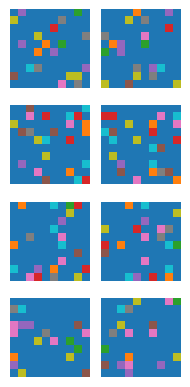

Test Example


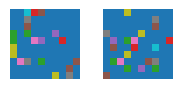

In [78]:
display_task(task, size_per_grid=1)

### INPUT SEQUENCE FORMAT: experiments / options

1. Interleaved (individual example mapppings get priority):
   1. x,y,x,y,...
   2. NB: grid -> seq uses the ordinary numpy method
   3. i.e. grids are flattened using np / jnp grid.flatten(), then padded and concatenated.
2. Segregated (overall task mapping gets priority):
   1. x,x,x,..., #, y,y,y, ..., # pred
3. Experiment with different SCRATCHPAD SPACE.

In [ ]:
vocab = list(range(50))
named_tokens = {
    'pad_xy': 49,
    'pad_xxx_yyy': 48, 
    'pad_pred': 47, 
    'start_task': 46,
    'end_task': 45,
}

In [95]:
def format_task_inputs(task, pad_token=named_tokens['pad_xy']):
    seq = []
    mask = []
    for t in task.train_examples:
        # make the input sequence
        tflat = jnp.concatenate([t.input.flatten(), jnp.array([pad_token]), t.output.flatten(), jnp.array([pad_token])])
        seq.append(tflat)
        # make the mask for loss:
        # NB: not offset by 1 by definition;
        example_mask = jnp.concatenate([jnp.zeros_like(t.input.flatten()), jnp.array([0]), jnp.ones_like(t.output.flatten()), jnp.array([0])])
        mask.append(example_mask)
    seq = jnp.concatenate(seq)
    mask = jnp.concatenate(mask)
    return seq

### Overview of the pretraining pipeline

1. choose transformations + probabilities / other parameters
2. create tasks
3. create leave-n-out tasks per task
4. format tasks serially and batch for training
5. train

# Train

- model: try llama
- training: try pl / wandb

In [ ]:
import torch
from transformers import LlamaForCausalLM, LlamaConfig
from torch.utils.data import DataLoader
from transformers import get_linear_schedule_with_warmup

# Create custom LLaMA config with RoPE
config = LlamaConfig(
    vocab_size=128,  # Adjust based on your grid encoding
    hidden_size=512, 
    intermediate_size=1024,
    num_hidden_layers=8,
    num_attention_heads=8,
    max_position_embeddings=8192, # handle long sequences
    rms_norm_eps=1e-6
)

# Initialize model with random weights
model = LlamaForCausalLM(config)

In [ ]:
import math
import torch
from torch.optim.lr_scheduler import CosineAnnealingLR
from pytorch_lightning.callbacks import LearningRateMonitor
from transformers import get_linear_schedule_with_warmup

def warmup_cosine_scheduler(optimizer, warmup_steps, total_steps, min_lr=1e-7):
    """ Convenience function for cosine warmup.
    """
    def lr_lambda(current_step):
        if current_step < warmup_steps:
            return float(current_step) / float(max(1, warmup_steps))
        progress = float(current_step - warmup_steps) / float(max(1, total_steps - warmup_steps))
        return max(min_lr, 0.5 * (1.0 + math.cos(math.pi * progress)))
    
    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

def configure_optimizers(self):
    optimizer = torch.optim.AdamW(
        self.parameters(), 
        lr=self.config.learning_rate
    )
    
    # Calculate total steps
    total_steps = len(self.trainer.datamodule.train_dataloader()) * self.trainer.max_epochs
    warmup_steps = int(self.config.warmup_ratio * total_steps)
    
    if self.config.lr_scheduler_type == "linear_warmup_decay":
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )
    elif self.config.lr_scheduler_type == "one_cycle":
        scheduler = torch.optim.lr_scheduler.OneCycleLR(
            optimizer,
            max_lr=self.config.learning_rate,
            total_steps=total_steps,
            pct_start=self.config.warmup_ratio
        )
    elif self.config.lr_scheduler_type == "cosine":
        scheduler = warmup_cosine_scheduler(
            optimizer, 
            warmup_steps=warmup_steps,
            total_steps=total_steps,
            min_lr=self.config.min_lr
        )
    else:
        raise ValueError(f"Unknown scheduler type: {self.config.lr_scheduler_type}")
    
    return {
        "optimizer": optimizer,
        "lr_scheduler": {
            "scheduler": scheduler,
            "interval": "step",
            "frequency": 1,
        },
    }

In [ ]:
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint, LearningRateMonitor
from torch.utils.data import DataLoader
import wandb
from dataclasses import dataclass
from typing import Optional, Dict, Any


# optionally, this can be added to the callbacks
class PrintLRCallback(pl.Callback):
    def on_train_batch_start(self, trainer, pl_module, batch, batch_idx):
        if batch_idx % 100 == 0:
            optimizer = trainer.optimizers[0]
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Current learning rate: {current_lr:.2e}")


@dataclass
class TrainingConfig:
    """Configuration for training run"""
    experiment_name: str = "default-experiment"
    project_name: str = "my-llm-project"
    
    # Training hyperparameters
    learning_rate: float = 1e-4
    batch_size: int = 16
    max_epochs: int = 10

    # Scheduler hyperparameters
    lr_scheduler_type: str = "linear_warmup_decay"  # Options: linear_warmup_decay, one_cycle, cosine
    warmup_ratio: float = 0.1  # Percentage of steps for warmup
    min_lr: float = 1e-7  # Minimum learning rate
    
    # Infrastructure settings
    num_workers: int = 4
    precision: int = 16
    accelerator: str = "gpu"
    devices: int = 1
    
    # Checkpointing
    checkpoint_dir: str = "checkpoints"
    save_top_k: int = 3
    
    # Logging
    log_every_n_steps: int = 50
    
    # Model specific configs can go here
    model_config: Dict[str, Any] = None


class LitModel(pl.LightningModule):
    def __init__(self, model, config):
        super().__init__()
        self.model = model
        self.config = config
        self.save_hyperparameters(ignore=['model'])
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        # train step
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.compute_loss(outputs, targets)

        # train step logging
        perplexity = torch.exp(loss)
        self.log('train_perplexity', perplexity, prog_bar=True)
        if batch_idx % 100 == 0:
            grad_norm = torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=float('inf'))
            self.log('grad_norm', grad_norm)
        self.log('train_loss', loss, prog_bar=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        # val step
        inputs, targets = batch
        outputs = self(inputs)
        loss = self.compute_loss(outputs, targets)
        
        # val step logging
        self.log('val_loss', loss, prog_bar=True)
        return loss
    
    def compute_loss(self, outputs, targets):
        """ Computes the loss.
            TO DO: Implement other loss functions; only CE for now.
        """
        return torch.nn.functional.cross_entropy(outputs, targets)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.parameters(), 
            lr=self.config.learning_rate    
        )
        return optimizer
    
    def on_train_epoch_end(self):
        # Log weight histograms occasionally
        for name, param in self.named_parameters():
            if param.requires_grad:
                self.logger.experiment.log_histogram(
                    f"parameters/{name}", param, self.current_epoch
                )


def train(model, train_dataset, val_dataset, config=None):
    """
    Parameterized training function that accepts model, datasets, and config
    
    Args:
        model: Your PyTorch model
        train_dataset: Training dataset
        val_dataset: Validation dataset
        config: TrainingConfig object with experiment parameters
    """
    if config is None:
        config = TrainingConfig()
    
    # ensure checkpoint directory exists
    os.makedirs(config.checkpoint_dir, exist_ok=True)
    
    # Initialize wandb
    wandb_logger = WandbLogger(
        project=config.project_name, 
        name=config.experiment_name
    )
    # Wandb logging
    wandb_logger.experiment.config.update(
        {k: v for k, v in vars(config).items() if not k.startswith('_')}
    )
    # Print experiment URL
    print(f"\n✨ View experiment at: {wandb_logger.experiment.url} ✨\n")
    
    # Initialize the Lightning module
    lit_model = LitModel(model, config)
    
    # Create dataloaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config.batch_size, 
        shuffle=True, 
        num_workers=config.num_workers
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config.batch_size, 
        num_workers=config.num_workers
    )
    
    # Callbacks
    callbacks = [
        ModelCheckpoint(
            dirpath=config.checkpoint_dir,
            filename=f'{config.experiment_name}-' + '{epoch}-{val_loss:.2f}',
            save_top_k=config.save_top_k,
            monitor='val_loss',
            mode='min'
        ),
        LearningRateMonitor(logging_interval='step')
    ]
    
    # Initialize trainer
    trainer = pl.Trainer(
        max_epochs=config.max_epochs,
        accelerator=config.accelerator,
        devices=config.devices,
        precision=config.precision,
        logger=wandb_logger,
        callbacks=callbacks,
        log_every_n_steps=config.log_every_n_steps
    )
    
    # Start training
    trainer.fit(
        lit_model, 
        train_dataloaders=train_loader, 
        val_dataloaders=val_loader
    )
    
    # End training message
    print(f"\nTraining complete!")
    print(f"Best checkpoint: {callbacks[0].best_model_path}")
    print(f"View full results at: {wandb_logger.experiment.url}")

    # Return the trained model and final checkpoint path
    return {
        'model': lit_model,
        'checkpoint_path': callbacks[0].best_model_path if callbacks[0].best_model_path else None
    }

def run_experiment():
    """
    Higher-level experiment runner that instantiates model, datasets, and config
    """
    # Create experiment config
    config = TrainingConfig(
        experiment_name="llama-star-experiment",
        learning_rate=5e-5,
        max_epochs=20,
        # Add other parameters as needed
    )
    
    # Create model
    model = YourModelClass()  # Replace with your actual model
    train_dataset = YourDataset(split='train')  # Replace with your dataset
    val_dataset = YourDataset(split='val')      # Replace with your dataset
    
    # Run training
    results = train(model, train_dataset, val_dataset, config)
    print(f"Training complete. Best checkpoint: {results['checkpoint_path']}")

    wandb.finish()

# if __name__ == "__main__":
#     run_experiment()